In [1]:
pip install pandas numpy matplotlib tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, GlobalAveragePooling2D, ZeroPadding2D, Dense, Dropout, Flatten, BatchNormalization, Input, Activation, Add
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy

from sklearn.model_selection import train_test_split

import os
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

import sys
print("Python Version:", sys.version)
print("TensorFlow Version", tf.__version__)

Python Version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
TensorFlow Version 2.16.1


In [7]:
# using GPU for faster processing

phys_devices = tf.config.list_physical_devices('GPU')
if len(phys_devices) > 0:
    # use the first visible GPU
    tf.config.experimental.set_visible_devices(phys_devices[0], 'GPU')
    print(f"Using GPU device {phys_devices[0].name}\n")
else:
    print("No GPU devices found!\n")

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

No GPU devices found!

GPU is not available


In [9]:
# load furniture data from CSV files
furniture_df = pd.read_csv("furniture_data.csv")
furniture_sliding_df = pd.read_csv("furniture_sliding_data.csv")

# combine both datasets into a single dataframe
full_furniture_df = pd.concat([furniture_df, furniture_sliding_df], axis=0)

In [10]:
dev, test = train_test_split(furniture_df, train_size = 0.85, shuffle = True, random_state = 333)

In [11]:
dev.shape, test.shape

((76571, 3), (13513, 3))

In [13]:
# define batch size and image dimensions
BATCH_SIZE = 32
IMG_WIDTH  = 224
IMG_HEIGHT = 224

# data augmentation for training
train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                width_shift_range = 0.05,
                                height_shift_range = 0.05,
                                rotation_range = 40,
                                zoom_range = 0.1,
                                shear_range = 0.2,
                                brightness_range = [0.5, 1.0],
                                validation_split = 0.15, 
                                fill_mode = 'nearest',
                                horizontal_flip = True,)

# data normalization for testing
test_datagen = ImageDataGenerator(rescale = 1/255.0)

In [14]:
# create data generators for training, validation, and testing
train_ds = train_datagen.flow_from_dataframe(
    dataframe = dev,
    x_col = 'Image_Path',
    y_col = 'Furniture_Category',
    color_mode = 'rgb',
    class_mode = 'categorical',
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42,
    subset = 'training'
)

val_ds = train_datagen.flow_from_dataframe(
    dataframe = dev,
    x_col = 'Image_Path',
    y_col = 'Furniture_Category',
    color_mode = 'rgb',
    class_mode = 'categorical',
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)

test_ds = test_datagen.flow_from_dataframe(
    dataframe = test,
    x_col = 'Image_Path',
    y_col = 'Furniture_Category',
    color_mode = 'rgb',
    target_size = (IMG_WIDTH, IMG_HEIGHT),
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False  # maintain order for testing
)

Found 65084 validated image filenames belonging to 6 classes.
Found 11485 validated image filenames belonging to 6 classes.
Found 13513 validated image filenames belonging to 6 classes.


In [15]:
print(train_ds.class_indices)

{'beds': 0, 'chairs': 1, 'dressers': 2, 'lamps': 3, 'sofas': 4, 'tables': 5}


(32, 224, 224, 3)
(32, 6)
Label:  [0. 0. 1. 0. 0. 0.]


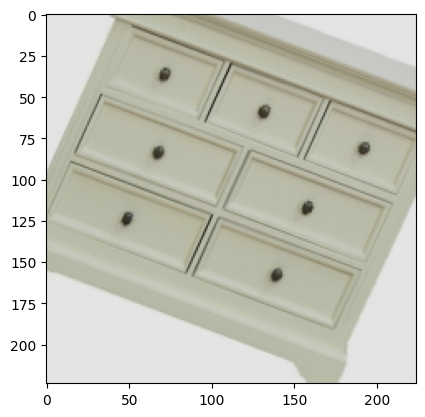

Label:  [0. 1. 0. 0. 0. 0.]


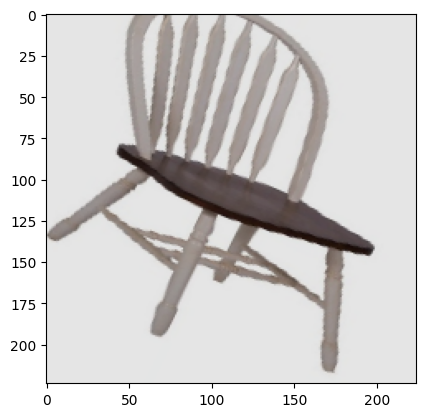

Label:  [0. 0. 0. 1. 0. 0.]


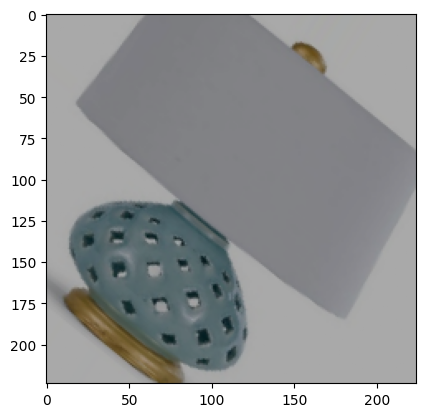

In [16]:
# Check image
batchX, batchY = train_ds.__next__()

print(batchX.shape)
print(batchY.shape)

for i in range(3):
    image = batchX[i]
    label = batchY[i]

    print('Label: ', label)

    plt.imshow(image)
    plt.show()

In [17]:
def identity_block(x, filters):
    x_skip = x

    # first layer
    x = Conv2D(filters[0], kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # second layer
    x = Conv2D(filters[1], kernel_size = (3, 3), strides = (1, 1), padding = 'same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # third layer
    x = Conv2D(filters[2], kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(x)
    x = BatchNormalization()(x)

    x = Add()([x, x_skip])
    x = Activation('relu')(x)

    return x

def convolutional_block(x, filters, strides = (2, 2)):
    x_skip = x

    # first convolutional layer
    x = Conv2D(filters[0], kernel_size = (1, 1), strides = strides, padding = 'valid')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # second convolutional layer
    x = Conv2D(filters[1], kernel_size = (3, 3), strides = (1, 1), padding = 'same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # third convolutional layer
    x = Conv2D(filters[2], kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(x)
    x = BatchNormalization()(x)

    x_skip = Conv2D(filters[2], kernel_size = (1, 1), strides = strides, padding = 'valid')(x_skip)
    x_skip = BatchNormalization()(x_skip)

    x = Add()([x, x_skip])
    x = Activation('relu')(x)

    return x

In [18]:
def ResNet50(shape=(224, 224, 3), classes = 1000):
    # input layer
    x_input = Input(shape)
    x = ZeroPadding2D(padding = (3, 3))(x_input)

    # stage 1
    x = Conv2D(64, kernel_size = (7, 7), strides = (2, 2), padding = 'valid')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same')(x)

    # stage 2
    x = convolutional_block(x, filters = [64, 64, 256], strides = (1, 1))
    for _ in range(2):  # 3 - 1
        x = identity_block(x, filters = [64, 64, 256])

    # stage 3
    x = convolutional_block(x, filters = [128, 128, 512])
    for _ in range(3):  # 4 - 1
        x = identity_block(x, filters = [128, 128, 512])

    # stage 4
    x = convolutional_block(x, filters = [256, 256, 1024])
    for _ in range(5):  # 6 - 1 
        x = identity_block(x, filters = [256, 256, 1024])

    # stage 5
    x = convolutional_block(x, filters = [512, 512, 2048])
    for _ in range(2):  # 3 - 1
        x = identity_block(x, filters = [512, 512, 2048])

    # output layer
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs = x_input, outputs = x, name = "ResNet50")
    return model

In [ ]:
# adjust 'classes' argument
resnet50_model = ResNet50(shape = (224, 224, 3), classes = 6)  
resnet50_model.summary()

In [20]:
# Adam configuration
opt = Adam(learning_rate = 0.001)
resnet50_model.compile(
    optimizer = opt,
    loss = CategoricalCrossentropy(), 
    metrics = [CategoricalAccuracy()]
)

In [26]:
# Early stopping callback configuration
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience = 10,
    restore_best_weights = True,
    verbose = 1,
    min_delta = 0.0001,
)

In [28]:
# adjust batch size and epochs as needed
history = resnet50_model.fit(train_ds, validation_data = val_ds, epochs = 5, batch_size = 32)

Epoch 1/5
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 5712s 3s/step - categorical_accuracy: 0.8596 - loss: 0.4081 - val_categorical_accuracy: 0.7574 - val_loss: 0.6775
Epoch 2/5
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 5771s 3s/step - categorical_accuracy: 0.8818 - loss: 0.3407 - val_categorical_accuracy: 0.4495 - val_loss: 1.6822
Epoch 3/5
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 5822s 3s/step - categorical_accuracy: 0.8965 - loss: 0.3050 - val_categorical_accuracy: 0.7801 - val_loss: 0.6305
Epoch 4/5
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 5712s 3s/step - categorical_accuracy: 0.9107 - loss: 0.2567 - val_categorical_accuracy: 0.4054 - val_loss: 1.7021
Epoch 5/5
2034/2034 ━━━━━━━━━━━━━━━━━━━━ 5713s 3s/step - categorical_accuracy: 0.9206 - loss: 0.2355 - val_categorical_accuracy: 0.8482 - val_loss: 0.4437


In [30]:
test_loss, test_accuracy = resnet50_model.evaluate(test_ds)
test_loss, test_accuracy


423/423 ━━━━━━━━━━━━━━━━━━━━ 251s 592ms/step - categorical_accuracy: 0.8654 - loss: 0.4090


(0.39956292510032654, 0.8669429421424866)

In [31]:
resnet50_model.save("task3_resnet50.keras")